<a href="https://colab.research.google.com/github/NhatVu/Customer_clustering/blob/main/ca683_Assignmen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
from tabulate import tabulate
from sklearn.cluster import KMeans
import seaborn as sns

## Understanding the data before processing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# origin_data_2010_2011_df = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/CA683/Assignment/online_retail_II.xlsx",sheet_name='Year 2010-2011')

Mounted at /content/drive/


In [9]:
# Retrieve the dataset
origin_data_2010_2011_df = pd.read_excel("./online_retail_II.xlsx", sheet_name='Year 2010-2011')

In [10]:
# View the data
unified_data = origin_data_2010_2011_df.copy()
unified_data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
summerized_data2 = unified_data.describe(include="object").T
print(tabulate(summerized_data2,headers=summerized_data2.columns,tablefmt='fancy_grid', stralign='center'))

╒═════════════╤═════════╤══════════╤════════════════════════════════════╤════════╕
│             │   count │   unique │                top                 │   freq │
╞═════════════╪═════════╪══════════╪════════════════════════════════════╪════════╡
│   Invoice   │  541910 │    25900 │               573585               │   1114 │
├─────────────┼─────────┼──────────┼────────────────────────────────────┼────────┤
│  StockCode  │  541910 │     4070 │               85123A               │   2313 │
├─────────────┼─────────┼──────────┼────────────────────────────────────┼────────┤
│ Description │  540456 │     4223 │ WHITE HANGING HEART T-LIGHT HOLDER │   2369 │
├─────────────┼─────────┼──────────┼────────────────────────────────────┼────────┤
│   Country   │  541910 │       38 │           United Kingdom           │ 495478 │
╘═════════════╧═════════╧══════════╧════════════════════════════════════╧════════╛


In [12]:
summerized_data = unified_data.describe(datetime_is_numeric=True).T.drop(columns=["mean"])
print(tabulate(summerized_data,headers=summerized_data.columns,tablefmt='fancy_grid', stralign='center'))

╒═════════════╤═════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════╕
│             │   count │         min         │         25%         │         50%         │         75%         │         max         │       std │
╞═════════════╪═════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═══════════╡
│  Quantity   │  541910 │      -80995.0       │         1.0         │         3.0         │        10.0         │       80995.0       │  218.081  │
├─────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┤
│ InvoiceDate │  541910 │ 2010-12-01 08:26:00 │ 2011-03-28 11:34:00 │ 2011-07-19 17:17:00 │ 2011-10-19 11:27:00 │ 2011-12-09 12:50:00 │  nan      │
├─────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────

In [13]:
# View basic information
print("General information")
unified_data.info()
print()
print("Total missing values")
print(unified_data.isnull().sum(),"\n")
print("Total unique items")
print(unified_data["StockCode"].nunique(),"\n")
print("Total number of invoices")
print(unified_data["Invoice"].nunique(),"\n")

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Total missing values
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64 

Total unique items
4070 

Total number of invoices
25900 



In [14]:
# customer id missing alot. We can't do customer segmentation if don't have customerId -> have to drop null row 
# Basic preprocessing
# Drop null values
unified_data.dropna(inplace=True)
# Remove canceled invoice
unified_data = unified_data[~unified_data["Invoice"].str.contains("C",na=False)]
# temp = unified_data[unified_data["Invoice"].str.contains("C",na=False)]

In [15]:
# View the data after brief cleaning
summerized_data = unified_data.describe(datetime_is_numeric=True).T.drop(columns=["mean"])
print(tabulate(summerized_data,headers=summerized_data.columns,tablefmt='fancy_grid', stralign='center'))
summerized_data2 = unified_data.describe(include="object").T
print(tabulate(summerized_data2,headers=summerized_data2.columns,tablefmt='fancy_grid', stralign='center'))

╒═════════════╤═════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════╕
│             │   count │         min         │         25%         │         50%         │         75%         │         max         │       std │
╞═════════════╪═════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═══════════╡
│  Quantity   │  397925 │         1.0         │         2.0         │         6.0         │        12.0         │       80995.0       │  180.42   │
├─────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┤
│ InvoiceDate │  397925 │ 2010-12-01 08:26:00 │ 2011-04-07 11:12:00 │ 2011-07-31 14:39:00 │ 2011-10-20 14:33:00 │ 2011-12-09 12:50:00 │  nan      │
├─────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────

In [16]:
unified_data.quantile([0, .25, 0.5, 0.75, 0.9, 0.99, 1], axis=0).T

,0.00,0.25,0.50,0.75,0.90,0.99,1.00
Quantity,1.0,2.00,6.00,12.00,24.00,120.00,80995.00
Price,0.0,1.25,1.95,3.75,6.35,14.95,8142.75
Customer ID,12346.0,13969.00,15159.00,16795.00,17725.00,18211.00,18287.00


In [17]:
# need to remove records where price = 0 because it nonsense 
# looking at the summary stat table, quantity and price are high right skew. 
# based on the suggestion of Chen (2012), Data mining for the online retail industry, we will remove top 1% of the rightmost 
rare_quantity = unified_data[unified_data['Quantity'] > 100].shape[0] / unified_data.shape[0]
rare_price = unified_data[unified_data["Price"] > 15].shape[0] / unified_data.shape[0]

print(f'rare quantity %: {rare_quantity * 100}')
print(f'rare_price %: {rare_price * 100}')

unified_data = unified_data[unified_data['Quantity'] < 100]
unified_data = unified_data[unified_data["Price"] < 15]
print(f'shape: {unified_data.shape}')

rare quantity %: 1.172331469498021
rare_price %: 0.8795627316705409
shape: (387728, 8)


[Text(0.5, 1.0, 'Data distribution of Quantity')]

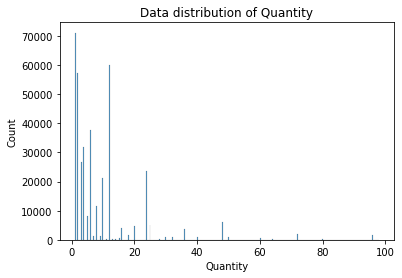

In [18]:
# View distribution
sns.histplot(x = 'Quantity', data=unified_data).set(title="Data distribution of Quantity")

[Text(0.5, 1.0, 'Data distribution of Price')]

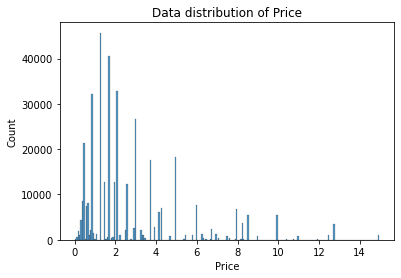

In [19]:
# View distribution
sns.histplot(x='Price', data= unified_data).set(title='Data distribution of Price')

## Generating advanced RFMT figures

In [20]:
# Retrieve Recency, Frequency, Monetary
examined_date = unified_data["InvoiceDate"].max()
unified_data["PurchaseIntervalTime"] = unified_data["InvoiceDate"]
unified_data["TotalSpent"]= unified_data["Price"]*unified_data["Quantity"]
new_advanced_field = {
    "InvoiceDate":lambda date:(examined_date-date.max()).days,
    "Invoice":lambda num: num.nunique(),
    "TotalSpent": lambda price:price.sum(),
    "PurchaseIntervalTime":lambda date: (examined_date - date.min()).days
}
advanced_rfm_df = unified_data.groupby("Customer ID").agg(new_advanced_field)
advanced_rfm_df.columns=["Recency","Frequency","Monetary","Tenure"]
# advanced_rfm_df["Recency"]=advanced_rfm_df["Recency"]/advanced_rfm_df["Frequency"]
advanced_rfm_df["Monetary"]=advanced_rfm_df["Monetary"]/advanced_rfm_df["Frequency"]
# Remove any monetary equal to 0
advanced_rfm_df = advanced_rfm_df[advanced_rfm_df["Monetary"]!=0]

In [21]:
advanced_rfm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4277.0,91.566051,100.041119,0.0,17.0,50.0000,142.0000,373.00
Frequency,4277.0,4.173252,7.412108,1.0,1.0,2.0000,5.0000,205.00
Monetary,4277.0,336.125078,329.482253,2.9,168.3,269.5575,399.2395,7206.26
Tenure,4277.0,221.668459,117.856796,0.0,111.0,247.0000,325.0000,373.00


## Data Mining & Analyse the advanced RFMT figures

In [ ]:
# flow: remove top 1% from original data -> min-max sacle -> draw histogram plot -> if right skew, use log-transform 

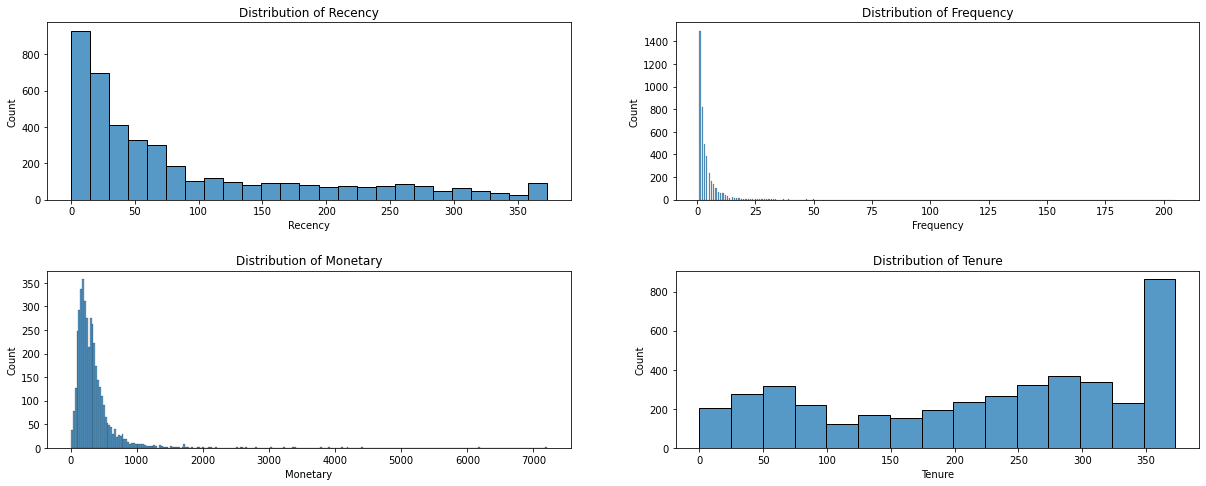

In [22]:
# Examine the shape of the distribution of the current data
plt.figure(figsize=(20,16));
# Plot the distributions of R,F,M
plt.subplot(4,2,1);
sns.histplot(advanced_rfm_df["Recency"]).set(title="Distribution of Recency");
plt.subplot(4,2,2);
sns.histplot(advanced_rfm_df["Frequency"]).set(title="Distribution of Frequency");
plt.subplot(4,2,3);
sns.histplot(advanced_rfm_df["Monetary"]).set(title="Distribution of Monetary");
plt.subplot(4,2,4);
sns.histplot(advanced_rfm_df["Tenure"]).set(title="Distribution of Tenure");
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

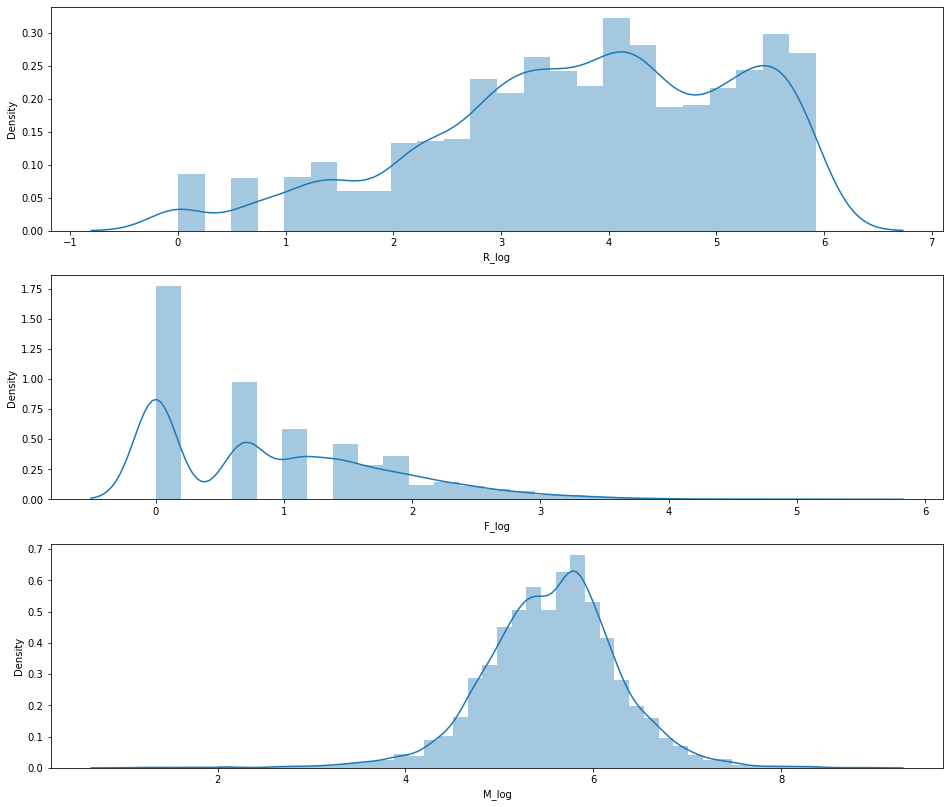

In [23]:
# advanced_rfm_df = advanced_rfm_df[advanced_rfm_df["Recency"]!=0]
# Because the data is skewed to the right so we need to transform by using Log Transformation
advanced_rfm_df["Monetary"]=advanced_rfm_df["Monetary"]
advanced_rfm_df["R_log"] = np.log(advanced_rfm_df["Recency"]+1)
advanced_rfm_df["F_log"] = np.log(advanced_rfm_df["Frequency"])
advanced_rfm_df["M_log"] = np.log(advanced_rfm_df["Monetary"])
# advanced_rfm_df["T_log"] = np.log(advanced_rfm_df["Tenure"]+1)

# Plot RFM distribution again
plt.figure(figsize=(16,14))
plt.subplot(3,1,1)
sns.distplot(advanced_rfm_df["R_log"])
plt.subplot(3,1,2);
sns.distplot(advanced_rfm_df["F_log"] )
plt.subplot(3,1,3)
sns.distplot(advanced_rfm_df["M_log"])
# plt.subplot(4,1,4)
# sns.distplot(advanced_rfm_df["T_log"])
plt.show();

In [24]:
advanced_rfm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4277.0,91.566051,100.041119,0.000000,17.000000,50.000000,142.000000,373.000000
Frequency,4277.0,4.173252,7.412108,1.000000,1.000000,2.000000,5.000000,205.000000
Monetary,4277.0,336.125078,329.482253,2.900000,168.300000,269.557500,399.239500,7206.260000
Tenure,4277.0,221.668459,117.856796,0.000000,111.000000,247.000000,325.000000,373.000000
R_log,4277.0,3.768877,1.430464,0.000000,2.890372,3.931826,4.962845,5.924256
F_log,4277.0,0.932817,0.893535,0.000000,0.000000,0.693147,1.609438,5.323010
M_log,4277.0,5.554792,0.728890,1.064711,5.125748,5.596782,5.989561,8.882705


In [25]:
# R, F, M and T have different scale, using MinMaxScaler to remove the effect of different unit metric 

from sklearn.preprocessing import MinMaxScaler
# Standardize mean and standard deviation
scaler = MinMaxScaler()
ad_data_process_log = advanced_rfm_df[["R_log","F_log","M_log","Tenure"]]
# ad_data_process_log = advanced_rfm_df[["R_log","F_log","M_log","T_log"]]
scaler.fit(ad_data_process_log)
ad_data_process_norm = scaler.transform(ad_data_process_log)
ad_data_process_norm_df = pd.DataFrame(ad_data_process_norm)
ad_data_process_norm_df.columns = ["Recency","Frequency","Monetary","Tenure"]
ad_data_process_norm_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Recency,4277.0,0.64,0.24,0.0,0.49,0.66,0.84,1.0
Frequency,4277.0,0.18,0.17,0.0,0.00,0.13,0.30,1.0
Monetary,4277.0,0.57,0.09,0.0,0.52,0.58,0.63,1.0
Tenure,4277.0,0.59,0.32,0.0,0.30,0.66,0.87,1.0


In [26]:
ad_data_process_norm_df.quantile([.25, 0.5, 0.75, 0.8, 0.9, 0.99], axis=0).T

,0.25,0.50,0.75,0.80,0.90,0.99
Recency,0.487888,0.663683,0.837716,0.875429,0.940822,0.997728
Frequency,0.000000,0.130217,0.302355,0.302355,0.412779,0.626000
Monetary,0.519447,0.579697,0.629938,0.643254,0.681028,0.801112
Tenure,0.297587,0.662198,0.871314,0.943164,0.981233,1.000000


## PCA

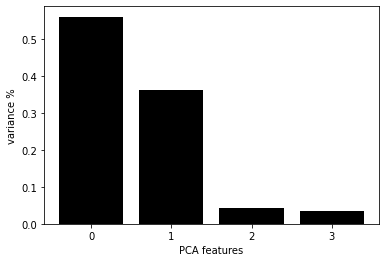

In [27]:
from sklearn.decomposition import PCA
# Standardize the data to have a mean of ~0 and a variance of 1
# x_std = StandardScaler().fit_transform(ad_data_process_log)
# Create a PCA instance: pca
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(ad_data_process_norm)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black');
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

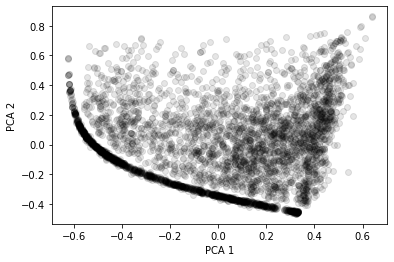

In [32]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## Create the customer segments with K-means++ algorithm 

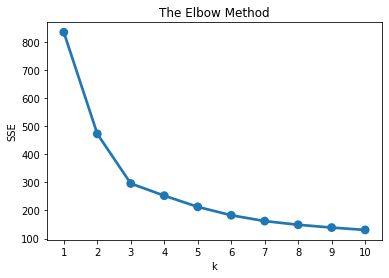

In [33]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(ad_data_process_norm)
    sse[k] = kmeans.inertia_
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show();

For n_clusters = 2 The average silhouette_score is : 0.39621252691623055
For n_clusters = 3 The average silhouette_score is : 0.4003061580142006
For n_clusters = 4 The average silhouette_score is : 0.3477953837918492


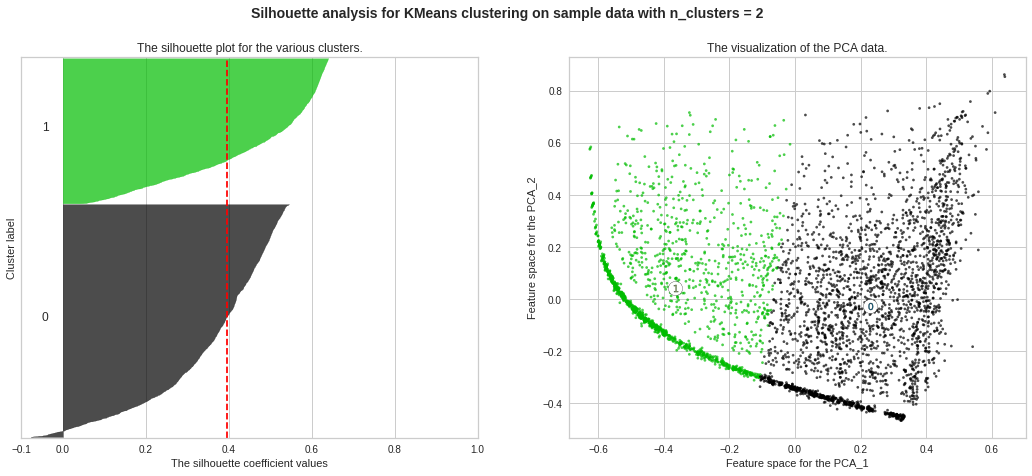

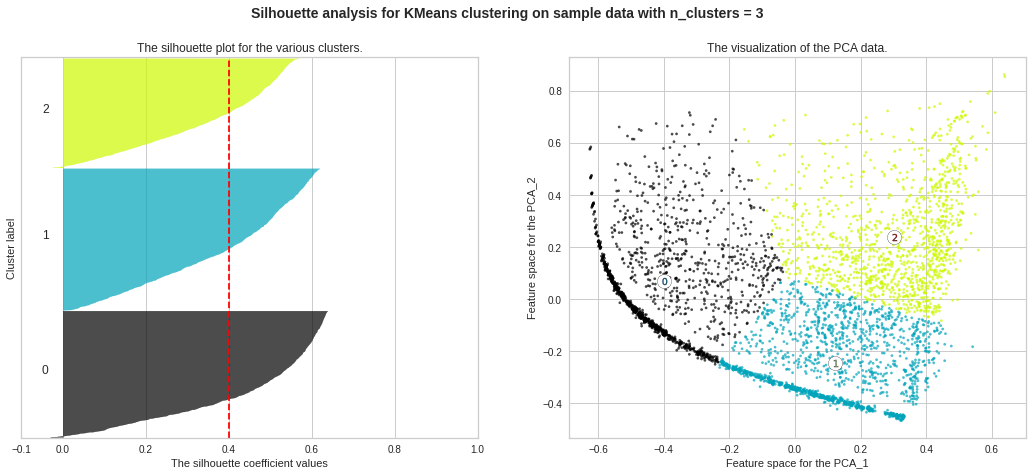

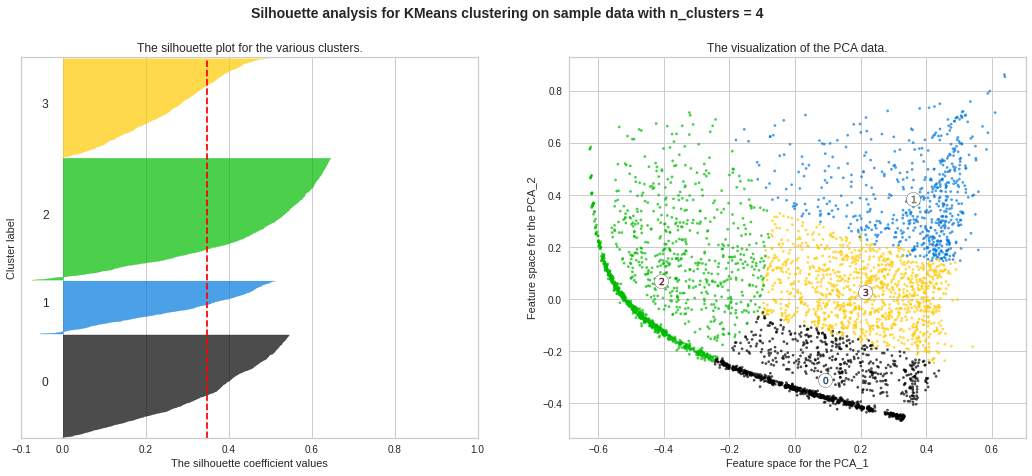

In [34]:
from sklearn import metrics
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm


range_n_clusters = [2, 3, 4]
# X = ad_data_process_norm
X = PCA_components
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the PCA data.")
    ax2.set_xlabel("Feature space for the PCA_1")
    ax2.set_ylabel("Feature space for the PCA_2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
# PCA does not change the relative relationship among features. If the dimension of PCA is the same as the original one,
# silhouette score will not be changed. However, using PCA is better to visualize data clusters
# Data points between clusters seperated well

In [35]:
# Choose k=3 and fit data set to k-means model
X = ad_data_process_norm
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X)
# Assign k-means labels to cluster labels
cluster_labels = kmeans.labels_
# Assign cluster labels to original pre-transformed data set
data_process_k4 = advanced_rfm_df.assign(Cluster = cluster_labels)
# Group data set by k-means cluster
cluster_data = data_process_k4.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean'],
    'Tenure': ['mean', 'count']
}).round(0)
cluster_data.columns = ['Recency', 'Frequency', 'Monetary', 'Tenure', 'Size']
cluster_data

,Recency,Frequency,Monetary,Tenure,Size
Cluster,,,,,
0,18.0,9.0,365.0,318.0,1237
1,45.0,2.0,346.0,77.0,1434
2,190.0,2.0,305.0,277.0,1606


* how evaluate customer segmentation 
- T: >= 6 months ---> long term user , < 6 months ---> short-term user 
- R: >= 1 month --> lost user, < 1 motnh --> non-lost user 
- F and M: Both >= 50% -> valuable user ,Both < 5-% -> non-valuable user 

In [36]:
ad_data_process_log.quantile([.25, 0.5, 0.75, 0.8, 0.9, 0.99], axis=0).T

,0.25,0.50,0.75,0.80,0.90,0.99
R_log,2.890372,3.931826,4.962845,5.186265,5.573672,5.910797
F_log,0.000000,0.693147,1.609438,1.609438,2.197225,3.332205
M_log,5.125748,5.596782,5.989561,6.093665,6.388987,7.327799
Tenure,111.000000,247.000000,325.000000,351.800000,366.000000,373.000000


In [37]:
threshold_T = 30*6 
threshold_R = 30
threshold_F_M = 0.5 
# long-term user, valuable user, lost user 
cluster_data['Longterm'] = cluster_data['Tenure'] > threshold_T
cluster_data['Lost'] = cluster_data['Recency'] >= threshold_R
cluster_data['Valuable'] = (cluster_data['Frequency'] >= cluster_data['Frequency'].quantile(threshold_F_M)) & (cluster_data['Monetary'] >= cluster_data['Monetary'].quantile(threshold_F_M))
cluster_data['Percentage'] = cluster_data['Size'] / cluster_data['Size'].sum() * 100
cluster_data[['Longterm', 'Lost', 'Valuable', 'Percentage']]

,Longterm,Lost,Valuable,Percentage
Cluster,,,,
0,True,False,True,28.922142
1,False,True,True,33.528174
2,True,True,False,37.549684


### Cluster explaination 
- Cluster 0 occupies 28.92%, It is long-term, non-lost and valuable users. Therefore, cluster 0 belongs to high-quality users. The retailers need to retain good relations with these users. 

- Cluster 1 is short-term, lost but valuable users and takes up 33.53% of all users. This cluster can contain new and high potential users.  It needs more investigation to explain why short-term and valuable users don’t commit to the stores. The quality of the website and the quality of customer services can make users leave the stores. 

- Cluster 2 is long-term, lost and non-valuable users.  This is a type of user that buy products for a long time ago. They can buy less frequently and move to another store. This cluster can be ignored.


# Hierarchical Clustering

## Dendrograms for Hierarchical Clustering

In [39]:
ad_data_process_norm_df.shape

(4277, 4)

In [38]:
num_samples = ad_data_process_norm_df.shape[0]
print(f'number samples: {num_samples}')

number samples: 4277


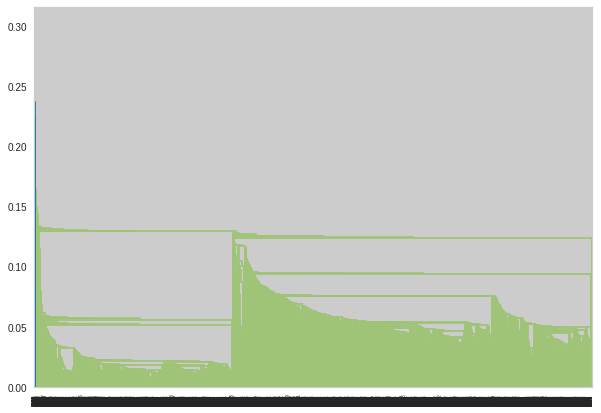

In [60]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

X = ad_data_process_norm
linked = linkage(X, 'single')

labelList = range(1, num_samples+1)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

## Hierarchical Clustering via Scikit-Learn


In [55]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
labels = cluster.labels_

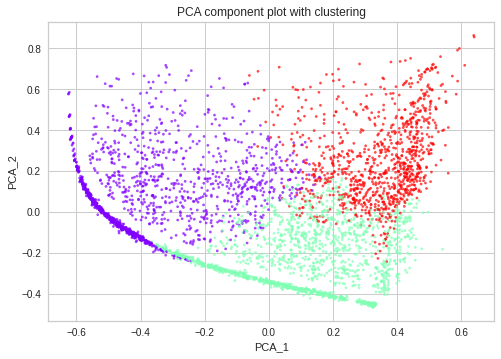

In [56]:
plt.scatter(
        PCA_components.iloc[:, 0], PCA_components.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=labels, cmap = 'rainbow', edgecolor="k"
    )
plt.title('PCA component plot with clustering')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.35869690678615757
For n_clusters = 3 The average silhouette_score is : 0.35869690678615757
For n_clusters = 4 The average silhouette_score is : 0.35869690678615757


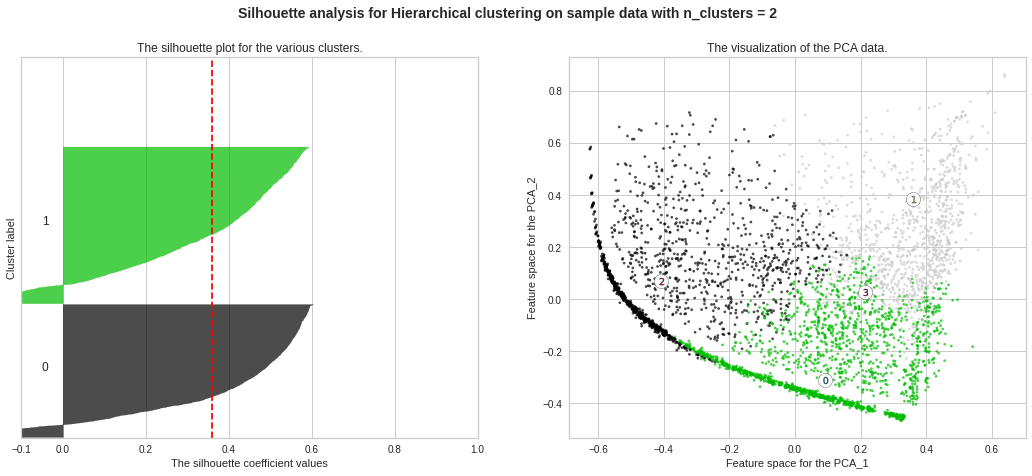

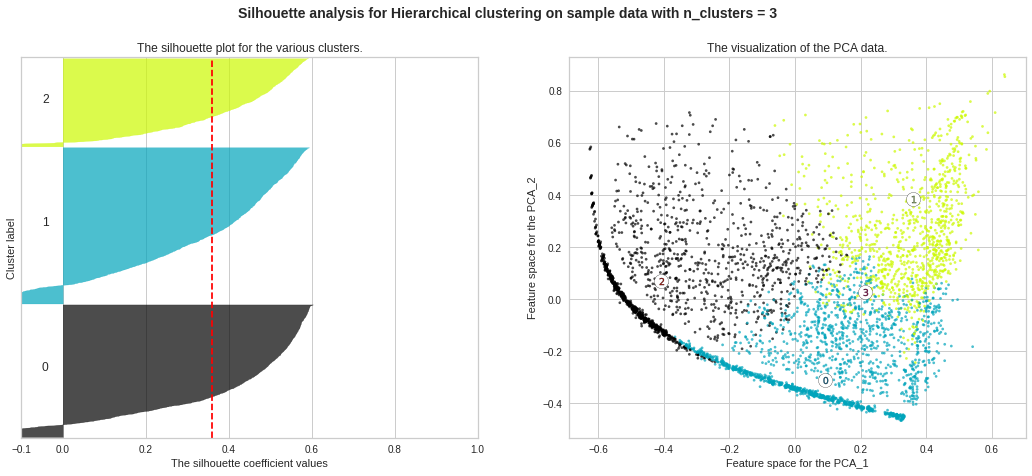

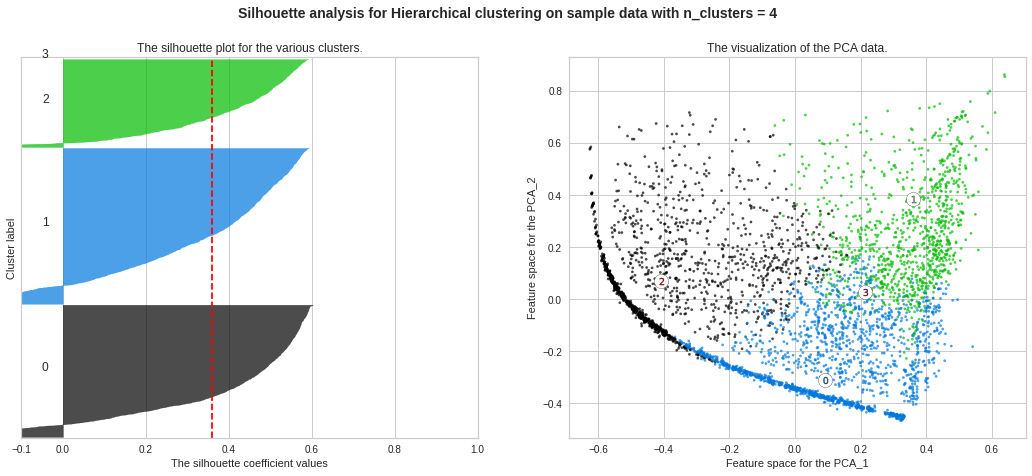

In [58]:
from sklearn import metrics
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm


range_n_clusters = [2, 3, 4]
# X = ad_data_process_norm
X = PCA_components
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)
    cluster_labels = cluster.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the PCA data.")
    ax2.set_xlabel("Feature space for the PCA_1")
    ax2.set_ylabel("Feature space for the PCA_2")

    plt.suptitle(
        "Silhouette analysis for Hierarchical clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()